In [2]:
!nvidia-smi

Sat Oct 16 22:29:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    57W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]


Text(0.5, 1.0, 'Very unbalanced Class')

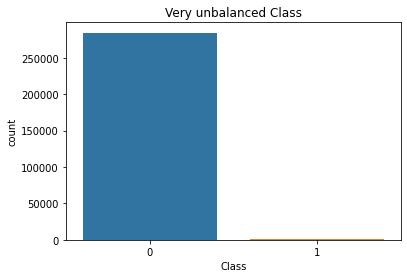

In [4]:
df = pd.read_csv("creditcard.csv")
print(df.head())
sns.countplot(x=df.Class).set_title('Very unbalanced Class')

Use RobustScaler which is less prone to outliers to normalized Amount and Time. 

In [5]:
df['Scaled_Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Scaled_Time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1,  inplace = True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount,Scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


Strafied train, test, val split so that there are equal numbers of fraud 
cases in each splits.

In [6]:
X = df.drop("Class",axis = 1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.1, 
                                                  stratify = y_train)

print("X:", X.shape, y.shape )
print("Train:", X_train.shape, y_train.shape )
print("Test:", X_test.shape, y_test.shape )
print("Val:", X_val.shape, y_val.shape )

print("{:0.3f} % of fraud case in dataframe.".format(((y==1).astype(int).sum())/((y==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Train split.".format(((y_train==1).astype(int).sum())/((y_train==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Val split.".format(((y_val==1).astype(int).sum())/((y_val==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Test split.".format(((y_test==1).astype(int).sum())/((y_test==0).astype(int).sum())*100) )

X: (284807, 30) (284807,)
Train: (230693, 30) (230693,)
Test: (28481, 30) (28481,)
Val: (25633, 30) (25633,)
0.173 % of fraud case in dataframe.
0.173 % of fraud case in Train split.
0.172 % of fraud case in Val split.
0.172 % of fraud case in Test split.


In [7]:
def focal_loss(alpha, gamma):
  """Focal Loss Functiion: FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
  Put more emphasis on fraudulent cases incompare to nonfraudulent cases during
  training."""
  def calc_focal_loss(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true , tf.float32 )

    p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
    loss = (alpha*y_true+(1.0-alpha)*(1.0-y_true))*tf.pow((1.0-p_t),gamma)*-K.log(p_t+K.epsilon())
    return tf.reduce_sum(loss)
  return calc_focal_loss

def f1(y_true, y_pred):
    """F1 score = 2* (precison * recall) /(precision + recall) """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true , tf.float32 )
    ypred = tf.cast(y_pred >=0.5, tf.float32)

    tp = tf.reduce_sum(y_true*ypred) 
    predicted_positive = tf.reduce_sum(y_pred) 
    actual_positive = tf.reduce_sum(y_true) 
    precision = tp/(predicted_positive+K.epsilon()) 
    recall = tp/(actual_positive+K.epsilon()) 
    
    return 2*( (precision * recall) / (precision + recall+K.epsilon()) )

In [8]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, 
                        input_shape=(30,),
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.relu),
  tf.keras.layers.Dense(64, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.relu),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.relu),
  tf.keras.layers.Dense(1, 
                        kernel_initializer=tf.keras.initializers.GlorotNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(),
                        activation=tf.nn.sigmoid)])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = focal_loss(alpha=0.25, gamma=3.0),
              metrics=[tf.keras.metrics.AUC(curve="PR"),#Precision-Recall-Curve
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto',
                                              patience=20, min_delta=0.0001,
                                               restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                  patience=20,min_delta=0.00001,
                                                  verbose=1,mode='auto')]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time

"""Note that batch_size is unusualy high becasue we want to make sure  in each
batch there are some Fradulant cases to learn."""

train_history = model.fit(X_train, y_train, batch_size=1024, epochs=100,
                          shuffle= True, validation_data=(X_val,y_val),
                          callbacks=callbacks)

Epoch 1/100
226/226 [==============================] - 4s 11ms/step - loss: 23.7801 - auc: 0.0342 - precision: 0.0031 - recall: 0.1504 - val_loss: 3.2838 - val_auc: 0.1767 - val_precision: 0.7000 - val_recall: 0.1591
Epoch 2/100
226/226 [==============================] - 2s 7ms/step - loss: 1.9610 - auc: 0.2790 - precision: 0.7760 - recall: 0.2431 - val_loss: 1.5695 - val_auc: 0.3626 - val_precision: 0.8095 - val_recall: 0.3864
Epoch 3/100
226/226 [==============================] - 2s 7ms/step - loss: 1.1252 - auc: 0.3848 - precision: 0.8431 - recall: 0.3233 - val_loss: 1.1421 - val_auc: 0.4244 - val_precision: 0.8400 - val_recall: 0.4773
Epoch 4/100
226/226 [==============================] - 2s 8ms/step - loss: 0.8229 - auc: 0.4991 - precision: 0.8611 - recall: 0.3885 - val_loss: 0.8568 - val_auc: 0.4749 - val_precision: 0.7895 - val_recall: 0.3409
Epoch 5/100
226/226 [==============================] - 2s 7ms/step - loss: 0.6266 - auc: 0.5802 - precision: 0.8660 - recall: 0.4211 - val

In [10]:
def plot_train_history(train_history):
  fig, axs = plt.subplots(1,2, figsize=(20,8))
  axs[0].plot(train_history.history['loss'])
  axs[0].plot(train_history.history['val_loss'])
  axs[0].set_title("Model Training and Testing loss:")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("loss")
  axs[0].legend(['Train', "Val"])
  
  axs[1].plot(train_history.history['auc'])
  axs[1].plot(train_history.history['val_auc'])
  axs[1].set_title("AUC-Precision-Recall-curve Training and Testing:")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("AUC-PR")
  axs[1].legend(['Train', "Val"])

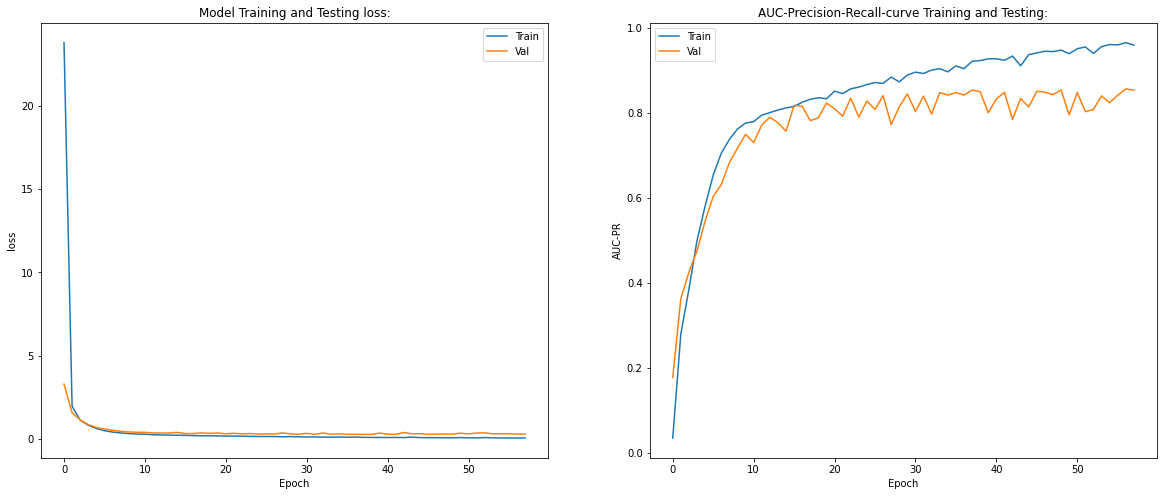

In [11]:
plot_train_history(train_history)

In [12]:
train_loss, train_aucpr, train_pre, train_recall = model.evaluate(X_train, y_train)
print("Train AUC-PR:", train_aucpr)
print("Train Precission: ", train_pre)
print("Train Recall: ", train_recall)
print("Train F1 score: ", 2*((train_pre*train_recall)/(train_pre+train_recall)) )

7210/7210 [==============================] - 39s 5ms/step - loss: 0.0028 - auc: 0.9264 - precision: 0.9759 - recall: 0.8120
Train AUC-PR: 0.9264253377914429
Train Precission:  0.9759036302566528
Train Recall:  0.8120300769805908
Train F1 score:  0.8864569159306025


In [13]:
test_loss, test_aucpr, test_pre, test_recall = model.evaluate(X_test, y_test)
print("Test AUC-PR:", test_aucpr)
print("Test Precission: ", test_pre)
print("Test Recall: ", test_recall)
print("Test F1 score: ", 2*((test_pre*test_recall)/(test_pre+test_recall)) )

891/891 [==============================] - 5s 5ms/step - loss: 0.0068 - auc: 0.8252 - precision: 0.9500 - recall: 0.7755
Test AUC-PR: 0.8252214789390564
Test Precission:  0.949999988079071
Test Recall:  0.7755101919174194
Test F1 score:  0.8539325720793429


Text(0.5, 0.98, 'Confusion Matrix of Test data')

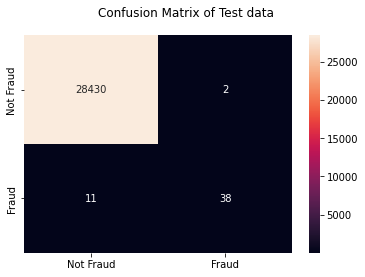

In [14]:
y_pred_test = model.predict(X_test) >= 0.5

cMatrix = confusion_matrix(y_true=y_test,y_pred=y_pred_test)
classes = ("Not Fraud", "Fraud")
ax = sns.heatmap(cMatrix,annot=True,fmt="d",xticklabels=classes,
                 yticklabels=classes)
plt.suptitle('Confusion Matrix of Test data')

In [15]:
model.save('credit_card_fraud_detect.h5')